<a href="https://colab.research.google.com/github/BackBencher2424/BA820_Team_14_Project/blob/VG_M2/BA820_M2_Q1_Vishesh_Goyal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BA820 – Project M2**
**Project Title:** *Code Trends, Quantified: Mapping the Programming Language Ecosystem* <br>
**Section and Team Number:** *B1 Team 14* <br>
**Student Name:** *Vishesh Goyal*

##**Refined Problem Statement & Focus**

**M1 Question 1:** *Do programming languages naturally cluster into distinct groups based on shared technical features (syntax patterns, file types) and community signals (GitHub activity, Wikipedia view)?*

###**Elaborating Question for M2**
We will be dividing the question into sub questions and making a umbrella like structure for the questions for easier understang and better interpretability. We would also be adding the community signals features, `appeared` and `last_activity`, to better interpret the Evolution over time.


#### **Main Question**
Do programming languages form meaningful, stable clusters when combining technical fingerprints (file extensions + GitHub metadata) with community signals (GitHub activity, Wikipedia attention, users/jobs)?

#####**Sub Questions**

**Q1.** What clusters emerge from technical fingerprints (extensions + GitHub language metadata), and how interpretable are they?

**Q2.** What clusters emerge from community signals (GitHub/Wikipedia/users/jobs), and do they reflect market segmentation?

**Q3.** Do technical and community clusterings align, or do they reveal mismatches (similar tech, different adoption)?

## **Code**

###**EDA (Extended + Relevant to the specific question)**

####*Setup*

In [72]:
!pip -q install umap-learn #installs UMAP which is used for visualization (2D embedding).

In [73]:
import re                           # for parsing file-extension tokens
import numpy as np                  # numeric computing
import pandas as pd                 # data loading / wrangling

import matplotlib.pyplot as plt     # plotting

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

import umap                         # UMAP embedding for visualization

# Make pandas prints nicer
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Fix random seeds for reproducibility (important for "stability")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [74]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
path = '/content/drive/MyDrive/BA820 Unsupervised Machine Learning/Datasets/Project Dataset/languages.csv' # path to csv file
df = pd.read_csv(path)
display(df.head())

,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,isbndb,book_count,semantic_scholar,language_rank,github_repo,github_repo_stars,github_repo_forks,github_repo_updated,github_repo_subscribers,github_repo_created,github_repo_description,github_repo_issues,github_repo_first_commit,github_language,github_language_tm_scope,github_language_type,github_language_ace_mode,github_language_file_extensions,github_language_repos,wikipedia,wikipedia_daily_page_views,wikipedia_backlinks_count,wikipedia_summary,wikipedia_page_id,wikipedia_appeared,wikipedia_created,wikipedia_revision_count,wikipedia_related,features_has_comments,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,400.0,401,37.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,source.java,programming,java,java jav,11529980.0,https://en.wikipedia.org/wiki/Java_(programmin...,5242.0,11543.0,Java is a general-purpose computer programming...,15881.0,1995.0,2001.0,7818.0,javascript pizza ada csharp eiffel mesa modula...,True,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,349.0,351,48.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,source.js,programming,javascript,js _js bones cjs es es6 frag gs jake javascrip...,16046489.0,https://en.wikipedia.org/wiki/JavaScript,4264.0,8982.0,"JavaScript (), often abbreviated as JS, is a h...",9845.0,1995.0,2001.0,6131.0,java lua scheme perl self c python awk hyperta...,True,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,78.0,78,19.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,source.c,programming,c_cpp,c cats h idc,2160271.0,https://en.wikipedia.org/wiki/C_(programming_l...,6268.0,10585.0,"C (, as in the letter c) is a general-purpose,...",6021.0,2011.0,2001.0,7316.0,cyclone unified-parallel-c split-c cilk b bcpl...,True,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN
3,python,Python,NaN,pl,1991,Guido van Rossum,https://www.python.org/,python.org,1995.0,https://www.programiz.com/python-programming/k...,339.0,342,52.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,source.python,programming,python,py cgi fcgi gyp gypi lmi py3 pyde pyi pyp pyt ...,9300725.0,https://en.wikipedia.org/wiki/Python_(programm...,7204.0,6849.0,Python is a widely used high-level programming...,23862.0,1991.0,2001.0,6342.0,jython micropython stackless-python cython abc...,True,True,True,#,2022,2818037,46976,Centrum Wiskunde & Informatica,NaN,text,NaN
4,sql,SQL,NaN,queryLanguage,1974,Donald D. Chamberlin and Raymond F. Boyce,NaN,NaN,NaN,NaN,177.0,182,37.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SQL,source.sql,data,sql,sql cql ddl inc mysql prc tab udf viw,1222.0,https://en.wikipedia.org/wiki/SQL,3084.0,4159.0,SQL ( ( listen) ESS-kew-EL or ( listen) SEE-k...,29004.0,1986.0,2001.0,4153.0,sql-92 datalog linq powershell c sql-psm sqlpl...,True,False,True,--,2022,7179119,219617,IBM,0.0,text,NaN


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4303 entries, 0 to 4302
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   pldb_id                            4303 non-null   object 
 1   title                              4303 non-null   object 
 2   description                        823 non-null    object 
 3   type                               4303 non-null   object 
 4   appeared                           4303 non-null   int64  
 5   creators                           1100 non-null   object 
 6   website                            1375 non-null   object 
 7   domain_name                        715 non-null    object 
 8   domain_name_registered             502 non-null    float64
 9   reference                          1989 non-null   object 
 10  isbndb                             1086 non-null   float64
 11  book_count                         4303 non-null   int64

####*Preprocessing*

In [77]:
df.columns.tolist()     #converting all the alavilable columns names to list
df.columns              #displaying which columns are available

Index(['pldb_id', 'title', 'description', 'type', 'appeared', 'creators', 'website', 'domain_name', 'domain_name_registered', 'reference',
       'isbndb', 'book_count', 'semantic_scholar', 'language_rank', 'github_repo', 'github_repo_stars', 'github_repo_forks',
       'github_repo_updated', 'github_repo_subscribers', 'github_repo_created', 'github_repo_description', 'github_repo_issues',
       'github_repo_first_commit', 'github_language', 'github_language_tm_scope', 'github_language_type', 'github_language_ace_mode',
       'github_language_file_extensions', 'github_language_repos', 'wikipedia', 'wikipedia_daily_page_views', 'wikipedia_backlinks_count',
       'wikipedia_summary', 'wikipedia_page_id', 'wikipedia_appeared', 'wikipedia_created', 'wikipedia_revision_count',
       'wikipedia_related', 'features_has_comments', 'features_has_semantic_indentation', 'features_has_line_comments',
       'line_comment_token', 'last_activity', 'number_of_users', 'number_of_jobs', 'origin_com

In [78]:
#Keeping the columns that we are actually interested in
candidate_cols = [
    # identifiers
    "title", "type", "file_type",
    # time
    "appeared", "last_activity",
    # GitHub language metadata (technical)
    "github_language_type", "github_language_tm_scope", "github_language_ace_mode",
    "github_language_file_extensions",
    # GitHub activity (community-ish)
    "github_language_repos", "github_repo_stars", "github_repo_forks",
    # Wikipedia attention
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    # adoption / demand
    "number_of_users", "number_of_jobs",
]

#making sure that we have all the columns that are availale
candidate_cols = [c for c in candidate_cols if c in df.columns]

In [79]:
#checking the missing rate, i.e. how many values are missing in the each colums by total values
missing_rate = df[candidate_cols].isna().mean().sort_values()
missing_rate.to_frame("missing_rate").head(25)

,missing_rate
title,0.000000
type,0.000000
appeared,0.000000
last_activity,0.000000
number_of_users,0.000000
number_of_jobs,0.000000
wikipedia_daily_page_views,0.659307
wikipedia_backlinks_count,0.668603
wikipedia_revision_count,0.727399
file_type,0.746688


In [80]:
n_total = len(df)
n_with_ext = df["github_language_file_extensions"].notna().sum()        #number fo languages that have extensions mentioned in the github column

print("Total languages:", n_total)
print("Languages with github_language_file_extensions:", n_with_ext)
print("Percent with extensions:", round(100 * n_with_ext / n_total, 2), "%")

Total languages: 4303
Languages with github_language_file_extensions: 470
Percent with extensions: 10.92 %


#####*Checking for Skewness, because higly skewed features would impact the clustering distances. We would be using `log1p` to reduce the Skewness so that the outliers have the minimum impact on clustering.*

In [81]:
#These community metrics are strongly right-skewed (mean ≫ median and extreme maxima), so we apply log1p() and standardization to prevent a few highly popular languages from dominating distance-based clustering.

skew_cols = ["number_of_users", "number_of_jobs", "wikipedia_daily_page_views", "github_repo_stars"]
skew_cols = [c for c in skew_cols if c in df.columns]

df[skew_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_users,4303.0,13771.264467,227712.946798,0.0,0.0,20.0,230.0,7179119.0
number_of_jobs,4303.0,422.183825,12572.985441,0.0,0.0,0.0,0.0,771996.0
wikipedia_daily_page_views,1466.0,227.133015,783.552400,-1.0,9.0,24.0,99.0,13394.0
github_repo_stars,889.0,2127.402700,7554.016422,0.0,29.0,194.0,1071.0,88526.0


In [82]:
df[skew_cols].skew(numeric_only=True) #values >>1 confirms heavy right skewness

,0
number_of_users,22.601737
number_of_jobs,55.224695
wikipedia_daily_page_views,8.000938
github_repo_stars,7.384292


#####*Defining 2 Datasets for Clustering*

In [83]:
#Technical Fingerprints Dataset

df_tech = df[df["github_language_file_extensions"].notna()].copy()

print("Technical subset shape:", df_tech.shape)
df_tech[["title", "github_language_file_extensions", "github_language_type"]].head(10)


Technical subset shape: (470, 49)


,title,github_language_file_extensions,github_language_type
0,Java,java jav,programming
1,JavaScript,js _js bones cjs es es6 frag gs jake javascrip...,programming
2,C,c cats h idc,programming
3,Python,py cgi fcgi gyp gypi lmi py3 pyde pyi pyp pyt ...,programming
4,SQL,sql cql ddl inc mysql prc tab udf viw,data
5,C++,cpp c++ cc cp cxx h h++ hh hpp hxx inc inl ino...,programming
6,HTML,html hta htm htmlhl inc xht xhtml,markup
7,XML,xml adml admx ant axaml axml builds ccproj ccx...,data
8,PHP,php aw ctp fcgi inc php3 php4 php5 phps phpt,programming
9,Perl,pl al cgi fcgi perl ph plx pm psgi t,programming


In [84]:
#Full dataset for comunity only clustering
df_full = df.copy()
print("Full dataset shape:", df_full.shape)

Full dataset shape: (4303, 49)


#####*Helper Functions*

In [85]:
# Converts Columns to Numbers
def to_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series, errors="coerce")

# Log-transform helper (log1p works even when value = 0)
def add_log1p(df_in: pd.DataFrame, col: str) -> str:
    # Create a new column name like "log1p_number_of_users"
    new_col = f"log1p_{col}"
    # Fill NaN with 0 BEFORE log, because log(undefined) is not valid
    df_in[new_col] = np.log1p(df_in[col].fillna(0))
    return new_col

# Parse extension strings like: ".py .pyw .pyi" -> ["py", "pyw", "pyi"]
def parse_extensions(ext_str: str) -> list[str]:
    if pd.isna(ext_str) or not isinstance(ext_str, str):
        return []
    tokens = ext_str.strip().lower().split()            # split on spaces
    clean = []
    for t in tokens:
        t = t.strip()
        # keep letters/numbers/+/-/_ only (so c++ becomes c++)
        t = re.sub(r"[^a-z0-9_\+\-]", "", t)
        if 1 <= len(t) <= 12:
            clean.append(t)
    return clean

# Turn token into a safe column name
def safe_ext_col(token: str) -> str:
    return "ext_" + re.sub(r"[^a-z0-9]+", "_", token.lower()).strip("_")

###**Clustering**

####*Setup for Clustering*

In this section we build a numeric matrix `X_tech` suitable for clustering.

Features included:
- **Extension fingerprint one-hots** (top N most common extensions in the technical subset)
- GitHub language metadata categorical fields (one-hot)
- Community signals (log1p users/jobs/wiki/etc.)
- Simple time signals (appeared, last_activity)

Then we:
- impute missing numeric values with median
- standardize numeric features
- one-hot encode categorical features

In [86]:
#cleaning columns
#selecting numerical colums
numeric_base_cols = [
    "appeared", "last_activity",
    "number_of_users", "number_of_jobs",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    "github_language_repos", "github_repo_stars", "github_repo_forks",
]

# Convert to numeric if column exists
for c in numeric_base_cols:
    if c in df_tech.columns:
        df_tech[c] = to_numeric(df_tech[c])

# Wikipedia views sometimes uses negative placeholders -> treat as missing and impute with nan
if "wikipedia_daily_page_views" in df_tech.columns:
    df_tech.loc[df_tech["wikipedia_daily_page_views"] < 0, "wikipedia_daily_page_views"] = np.nan

# Basic sanity: out-of-range years -> NaN
for yc in ["appeared", "last_activity"]:
    if yc in df_tech.columns:
        df_tech.loc[(df_tech[yc] < 1800) | (df_tech[yc] > 2100), yc] = np.nan

df_tech[numeric_base_cols].head(5)

,appeared,last_activity,number_of_users,number_of_jobs,wikipedia_daily_page_views,wikipedia_backlinks_count,wikipedia_revision_count,github_language_repos,github_repo_stars,github_repo_forks
0,1995.0,2022.0,5550123,85206,5242.0,11543.0,7818.0,11529980.0,NaN,NaN
1,1995.0,2022.0,5962666,63993,4264.0,8982.0,6131.0,16046489.0,NaN,NaN
2,1972.0,2022.0,3793768,59919,6268.0,10585.0,7316.0,2160271.0,NaN,NaN
3,1991.0,2022.0,2818037,46976,7204.0,6849.0,6342.0,9300725.0,NaN,NaN
4,1974.0,2022.0,7179119,219617,3084.0,4159.0,4153.0,1222.0,NaN,NaN


In [87]:
#creating new columns which contains log1p values of the original columns in df_tech
log_cols = []
for c in [
    "number_of_users", "number_of_jobs",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    "github_language_repos", "github_repo_stars", "github_repo_forks",
]:
    if c in df_tech.columns:
        log_cols.append(add_log1p(df_tech, c))

print("Created log columns:", log_cols)
df_tech[log_cols].head(5)


Created log columns: ['log1p_number_of_users', 'log1p_number_of_jobs', 'log1p_wikipedia_daily_page_views', 'log1p_wikipedia_backlinks_count', 'log1p_wikipedia_revision_count', 'log1p_github_language_repos', 'log1p_github_repo_stars', 'log1p_github_repo_forks']


,log1p_number_of_users,log1p_number_of_jobs,log1p_wikipedia_daily_page_views,log1p_wikipedia_backlinks_count,log1p_wikipedia_revision_count,log1p_github_language_repos,log1p_github_repo_stars,log1p_github_repo_forks
0,15.529331,11.352839,8.564649,9.353921,8.964312,16.260461,0.0,0.0
1,15.601028,11.066545,8.358197,9.103089,8.721276,16.591001,0.0,0.0
2,15.148871,11.000766,8.743372,9.267288,8.897956,14.585745,0.0,0.0
3,14.851551,10.757413,8.882531,8.832004,8.755107,16.045603,0.0,0.0
4,15.786687,12.299645,8.034307,8.333270,8.331827,7.109062,0.0,0.0


In [88]:
### Standerdizing and One hot encoding the extensions that is listed for languages in the column "github_language_file_extensions"

TOP_N_EXT = 60  # <-- We can try 40, 60, 80 later for sensitivity checks

# Parse extension tokens for every row
ext_tokens = df_tech["github_language_file_extensions"].apply(parse_extensions)

# Count token frequencies
token_counts = pd.Series([t for row in ext_tokens for t in row]).value_counts()

# Choose most common tokens
top_tokens = token_counts.head(TOP_N_EXT).index.tolist()
top_cols = [safe_ext_col(t) for t in top_tokens]

# Build a 0/1 matrix (rows x top_tokens)
ext_matrix = np.zeros((len(df_tech), len(top_tokens)), dtype=int)
token_to_idx = {t: i for i, t in enumerate(top_tokens)}

# Convert each row's token list into a set, then fill matrix
for i, token_list in enumerate(ext_tokens):
    token_set = set(token_list)
    for t in token_set:
        j = token_to_idx.get(t)
        if j is not None:
            ext_matrix[i, j] = 1

df_ext = pd.DataFrame(ext_matrix, columns=top_cols, index=df_tech.index)

# Add a simple numeric feature: how many extensions are listed?
df_tech["num_extensions_listed"] = ext_tokens.apply(lambda x: len(set(x)))

print("Extension one-hot matrix shape:", df_ext.shape)
df_ext.head()

Extension one-hot matrix shape: (470, 60)


,ext_inc,ext_m,ext_fcgi,ext_cls,ext_t,ext_l,ext_fs,ext_pro,ext_pm,ext_sql,ext_gs,ext_pl,ext_v,ext_ms,ext_bf,ext_d,ext_cl,ext_e,ext_bas,ext_f,ext_bb,ext_rs,ext_cgi,ext_mod,ext_for,ext_h,ext_w,ext_jsx,ext_jq,ext_m4,ext_asc,ext_rno,ext_shader,ext_g,ext_q,ext_gd,ext_pwn,ext_prc,ext_cp,ext_n,ext_tst,ext_ch,ext_moo,ext_6pl,ext_6pm,ext_p6m,ext_nqp,ext_p6,ext_p6l,ext_pm6,ext_pl6,ext_spec,ext_rpy,ext_ecl,ext_j,ext_properties,ext_p,ext_rhtml,ext_ls,ext_lsp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
# Selecting Categorical Columns for Tech Clustering

cat_cols_tech = []
for c in ["type", "file_type", "github_language_type", "github_language_tm_scope", "github_language_ace_mode"]:
    if c in df_tech.columns:
        cat_cols_tech.append(c)

print("Categorical columns (tech):", cat_cols_tech)

Categorical columns (tech): ['type', 'file_type', 'github_language_type', 'github_language_tm_scope', 'github_language_ace_mode']


In [90]:
#combining and making the final X_tech matrix

# Combine engineered extension features into one table
df_model_tech = pd.concat([df_tech, df_ext], axis=1)

# Numeric columns for clustering (use log versions + time + num_extensions_listed)
num_cols_tech = ["appeared", "last_activity", "num_extensions_listed"] + log_cols
num_cols_tech = [c for c in num_cols_tech if c in df_model_tech.columns]  # defensive

print("Numeric columns (tech):", num_cols_tech)
print("Extension columns used:", len(top_cols))

# ColumnTransformer:
# - numeric: impute median + standardize
# - categorical: impute most frequent + one-hot encode
# - extension one-hots: pass through (already 0/1)
preprocess_tech = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_cols_tech),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_cols_tech),
        ("ext", "passthrough", top_cols),
    ],
    remainder="drop",
)

# Fit + transform to numeric matrix
X_tech = preprocess_tech.fit_transform(df_model_tech)

print("Final X_tech shape:", X_tech.shape)

Numeric columns (tech): ['appeared', 'last_activity', 'num_extensions_listed', 'log1p_number_of_users', 'log1p_number_of_jobs', 'log1p_wikipedia_daily_page_views', 'log1p_wikipedia_backlinks_count', 'log1p_wikipedia_revision_count', 'log1p_github_language_repos', 'log1p_github_repo_stars', 'log1p_github_repo_forks']
Extension columns used: 60
Final X_tech shape: (470, 554)


####*Visualising*

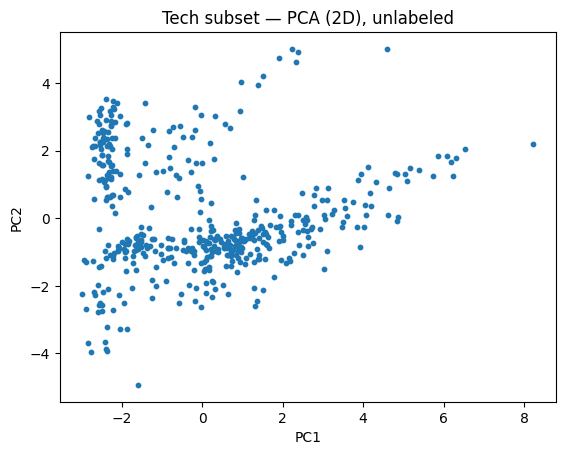

Explained variance ratio (PC1, PC2): [0.33174927 0.19848683]


In [91]:
# PCA 2D
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_tech_pca2 = pca2.fit_transform(X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech)

plt.figure()
plt.scatter(X_tech_pca2[:, 0], X_tech_pca2[:, 1], s=10)
plt.title("Tech subset — PCA (2D), unlabeled")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca2.explained_variance_ratio_)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


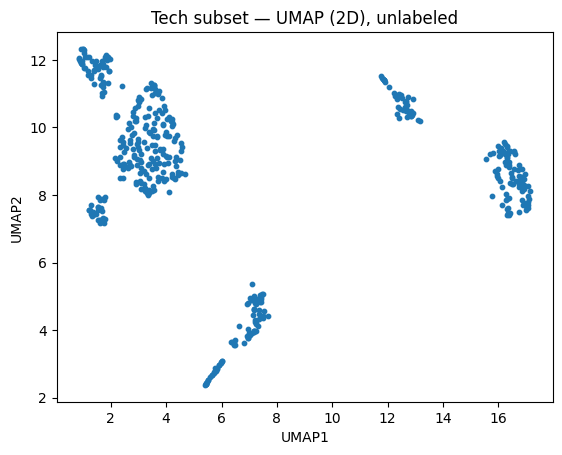

In [92]:
# UMAP 2D
umap2 = umap.UMAP(
    n_neighbors=20,          # controls local vs global structure
    min_dist=0.05,           # lower -> tighter clusters in visualization
    n_components=2,
    random_state=RANDOM_STATE
)

# UMAP needs a dense array in some environments; handle safely
X_tech_dense = X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech
X_tech_umap2 = umap2.fit_transform(X_tech_dense)

plt.figure()
plt.scatter(X_tech_umap2[:, 0], X_tech_umap2[:, 1], s=10)
plt.title("Tech subset — UMAP (2D), unlabeled")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

####*K Means Clustering on X_Tech*

We choose **k** using silhouette score over the full `X_Tech` matrix

In [93]:
# Trying k from 2..10 and compute silhouette
k_values = list(range(2, 11))
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_tech)
    score = silhouette_score(X_tech, labels)   # silhouette on high-dimensional X
    sil_scores.append(score)

results_k = pd.DataFrame({"k": k_values, "silhouette": sil_scores})
results_k

,k,silhouette
0,2,0.218743
1,3,0.226929
2,4,0.238310
3,5,0.239078
4,6,0.212925
5,7,0.213933
6,8,0.174662
7,9,0.167286
8,10,0.183190


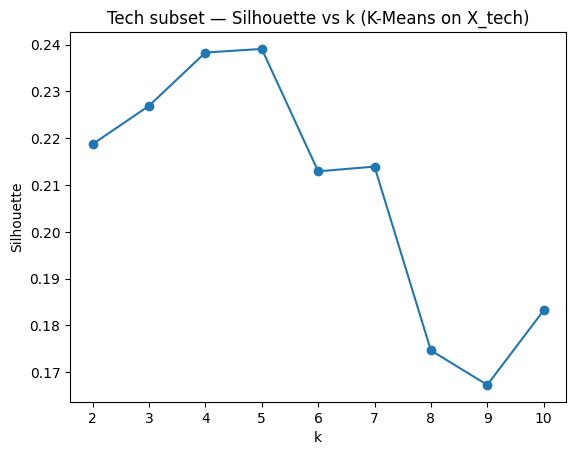

Best k (tech subset): 5


In [94]:
# Plot silhouette scores
plt.figure()
plt.plot(results_k["k"], results_k["silhouette"], marker="o")
plt.title("Tech subset — Silhouette vs k (K-Means on X_tech)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

best_k_tech = int(results_k.loc[results_k["silhouette"].idxmax(), "k"])
print("Best k (tech subset):", best_k_tech)

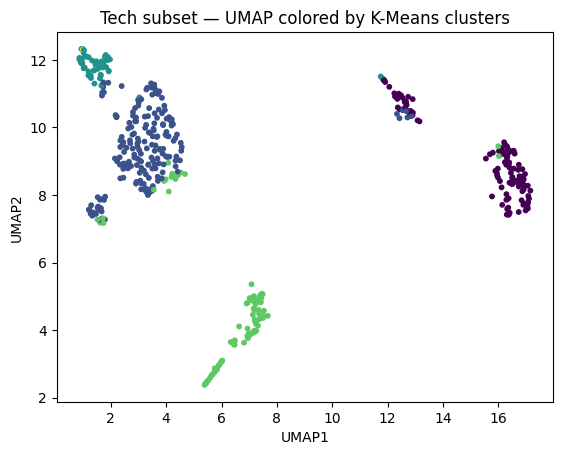

,title,cluster_kmeans_tech
0,Java,2
1,JavaScript,2
2,C,2
3,Python,2
4,SQL,2
5,C++,2
6,HTML,2
7,XML,4
8,PHP,2
9,Perl,2


In [101]:
# Fit final K-Means with best k
kmeans_tech = KMeans(n_clusters=best_k_tech, random_state=RANDOM_STATE, n_init=10)
labels_km_tech = kmeans_tech.fit_predict(X_tech)

# Plot clusters on UMAP
plt.figure()
plt.scatter(X_tech_umap2[:, 0], X_tech_umap2[:, 1], c=labels_km_tech, s=10)
plt.title("Tech subset — UMAP colored by K-Means clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

# Attach labels back to data
df_model_tech = df_model_tech.copy()
df_model_tech["cluster_kmeans_tech"] = labels_km_tech

df_model_tech[["title", "cluster_kmeans_tech"]].head(10)

####*Hierarchical Clustering on X_Tech*

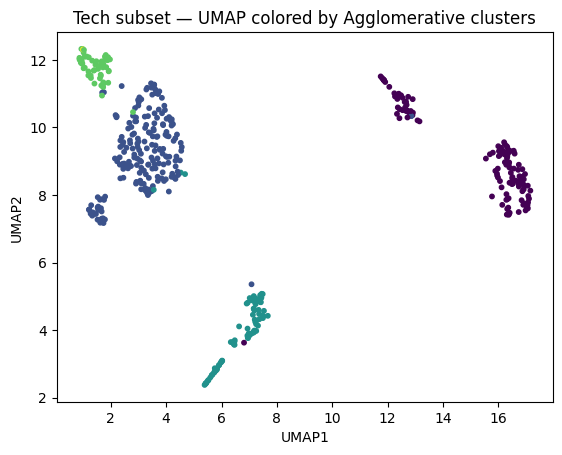

,title,cluster_kmeans_tech,cluster_agglom_tech
0,Java,2,3
1,JavaScript,2,3
2,C,2,3
3,Python,2,3
4,SQL,2,3
5,C++,2,3
6,HTML,2,3
7,XML,4,4
8,PHP,2,0
9,Perl,2,3


In [102]:
# AgglomerativeClustering requires dense input
X_tech_dense = X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech

agg_tech = AgglomerativeClustering(n_clusters=best_k_tech, linkage="ward")
labels_ag_tech = agg_tech.fit_predict(X_tech_dense)

# Plot clusters on UMAP
plt.figure()
plt.scatter(X_tech_umap2[:, 0], X_tech_umap2[:, 1], c=labels_ag_tech, s=10)
plt.title("Tech subset — UMAP colored by Agglomerative clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

df_model_tech["cluster_agglom_tech"] = labels_ag_tech
df_model_tech[["title", "cluster_kmeans_tech", "cluster_agglom_tech"]].head(10)

####*Compairing K Mean*

In [103]:
ari_methods = adjusted_rand_score(labels_km_tech, labels_ag_tech)
print("ARI (K-Means vs Agglomerative) on tech subset:", round(ari_methods, 4))

ARI (K-Means vs Agglomerative) on tech subset: 0.8112
